# Model Tester

This notebook is used to load and test models than have already been trained

In [1]:
import os, sys
qJetClassifier_path = os.path.abspath("/data/tdesrous/qJetClassifier")
sys.path.append(qJetClassifier_path)

from qJetClassifier import HLS4MLData150, qJetClassifier, JetDataset, accuracy
import torch
from torch import nn
from torch_geometric.loader import DataLoader
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import pennylane as qml
from torchmetrics.classification import  MultilabelROC
import matplotlib.pyplot as plt
import yaml
import glob

['/data/tdesrous/miniconda3/lib/python312.zip', '/data/tdesrous/miniconda3/lib/python3.12', '/data/tdesrous/miniconda3/lib/python3.12/lib-dynload', '', '/data/tdesrous/miniconda3/lib/python3.12/site-packages', '/data/tdesrous/qJetClassifier', '/data/tdesrous/qJetClassifier/tdesrous/qJetClassifier']


In [2]:
version = 'version_4'
results_path = os.path.join(qJetClassifier_path, "logs/lightning_logs/"+version+"/")

hparams_file = os.path.join(results_path, "hparams.yaml")
with open(hparams_file, 'r') as stream:
    model_params = yaml.safe_load(stream)

print(model_params)

files = glob.glob(os.path.join(results_path, "checkpoints/*.ckpt"))
print(files)

{'batch_size': 10, 'diff_method': 'adjoint', 'hidden_layer_size': 12, 'latent_space_size': 6, 'lr': 0.01, 'nb_ansatz_layers': 3, 'nb_epochs': 100, 'nb_node_features': 3, 'nb_reuploading': 3, 'nb_test_samples': 100, 'nb_train_samples': 1000, 'sum_observable': True}
['/data/tdesrous/qJetClassifier/logs/lightning_logs/version_4/checkpoints/epoch=99-step=8000.ckpt']


In [3]:
class LitQJetClassifier(L.LightningModule):
    def __init__(self, loss_fn):
        super().__init__()
        self.model = qJetClassifier(model_params)
        self.loss_fn = loss_fn
        self.model_params = model_params
        self.roc = MultilabelROC(num_labels=5)

        # for name, param in self.model.named_parameters():
        #     print(name, param)

    def training_step(self, batch, batch_idx):
        x, y = batch, batch.y[:batch.batch_size]
        y = torch.tensor(y)
        y_hat = self.model(x)
        # print(y_hat)
        loss = self.loss_fn(y_hat, y)
        acc = accuracy(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_accuracy', acc, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch, batch.y[:batch.batch_size]
        y = torch.tensor(y)
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        acc = accuracy(y_hat, y)
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('val_accuracy', acc, prog_bar=False, on_step=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch, batch.y[:batch.batch_size]
        y = torch.tensor(y)
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        acc = accuracy(y_hat, y)
        y = y.type(torch.LongTensor)
        self.log('test_loss', loss, on_step=True, on_epoch=True)
        self.log('test_accuracy', acc, on_step=True, on_epoch=True)
        self.roc.update(y_hat, y)
      
    def on_test_epoch_end(self) -> None:
        labels = ['g', 'q', 'W', 'Z', 't']
        fig_, ax_ = self.roc.plot(score=True, labels=labels)

        path = os.path.join(results_path, 'roc.png')
        fig_.savefig(path)
        self.roc.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.model_params['lr'])
        return optimizer

    def on_fit_start(self):
        self.logger.log_hyperparams(self.model_params)

In [4]:
x_test_file_path = "/data/tdesrous/qJetClassifier/data_test/processed/x_val_standard_6const_ptetaphi.npy"
y_test_file_path = "/data/tdesrous/qJetClassifier/data_test/processed/y_val_standard_6const_ptetaphi.npy"

test_dataset = JetDataset(x_test_file_path, y_test_file_path, 10000)

/data/tdesrous/miniconda3/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
GPU available: False, used: False
TPU availabl

Testing: |          | 0/? [00:00<?, ?it/s]

/data/tdesrous/miniconda3/lib/python3.12/site-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  data_dict[key] = torch.as_tensor(value)
/data/tdesrous/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_accuracy_epoch      0.5238999724388123
     test_loss_epoch        1.5509152592658997
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 1.5509152592658997,
  'test_accuracy_epoch': 0.5238999724388123}]

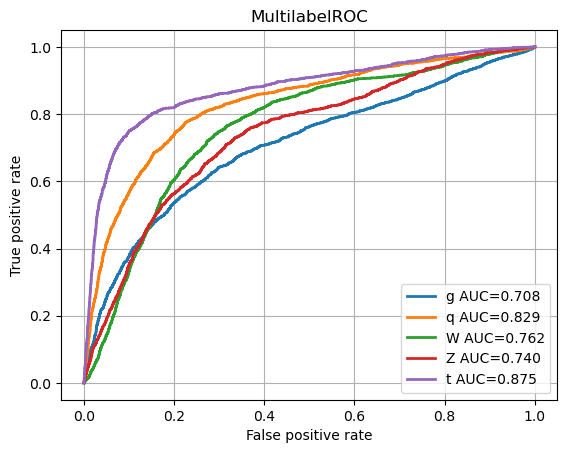

In [5]:
loss_fn = nn.CrossEntropyLoss()
model = LitQJetClassifier.load_from_checkpoint(files[0], loss_fn=loss_fn)
trainer = L.Trainer()

trainer.test(model, dataloaders=DataLoader(test_dataset))